In [4]:
pip install distance

Note: you may need to restart the kernel to use updated packages.


In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import glob
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/quora-question-pairs/test.csv
/kaggle/input/quora-question-pairs/train.csv
/kaggle/input/quora-question-pairs/sample_submission.csv


In [6]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this

from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE

from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
import distance

In [7]:
df = pd.read_csv("/kaggle/input/quora-question-pairs/train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


**Exploratory Data Analysis**

In [8]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


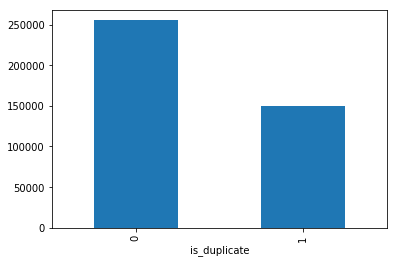

In [10]:
#Plotting duplicate/non-duplicate question pair 
df.groupby("is_duplicate")['id'].count().plot.bar()

In [11]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [12]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


In [13]:
#differentiating unique questions in the whole dataset. 

qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



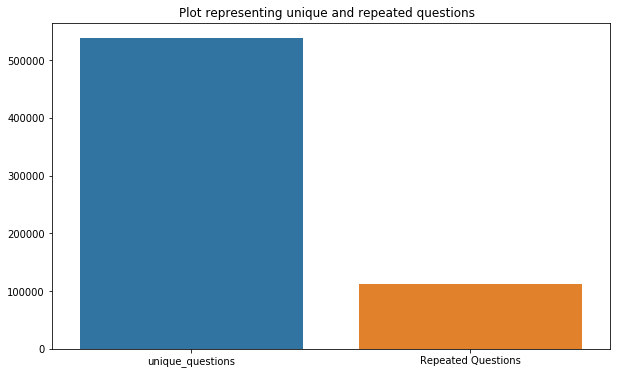

In [14]:
#Plotting unique vs repeating question pair.

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

In [15]:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


Maximum number of times a single question is repeated: 157



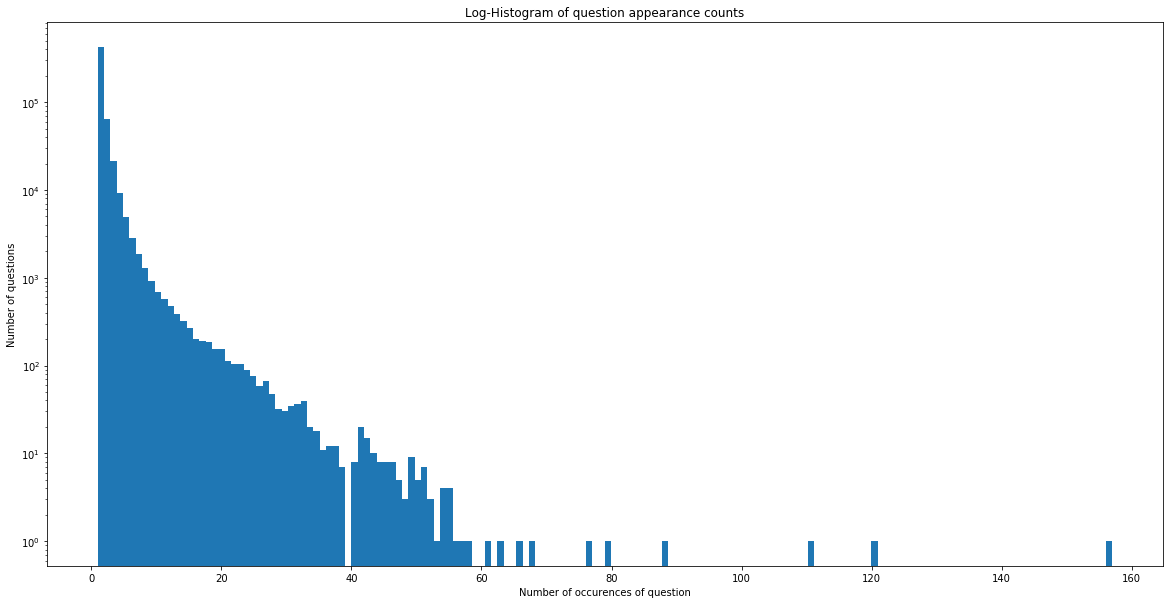

In [16]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))

In [17]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


In [18]:
# Filling the null values with ' '(space) 
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


**Basic Feature Extraction (before cleaning) **

* freq_qid1 = Frequency of qid1's
* freq_qid2 = Frequency of qid2's
* q1len = Length of q1
* q2len = Length of q2
* q1_n_words = Number of words in Question 1
* q2_n_words = Number of words in Question 2
* word_Common = (Number of common unique words in Question 1 and Question 2)
* word_Total =(Total num of words in Question 1 + Total num of words in Question 2)
* word_share = (word_common)/(word_Total)
* freq_q1+freq_q2 = sum total of frequency of qid1 and qid2
* freq_q1-freq_q2 = absolute difference of frequency of qid1 and qid2

In [19]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

In [20]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


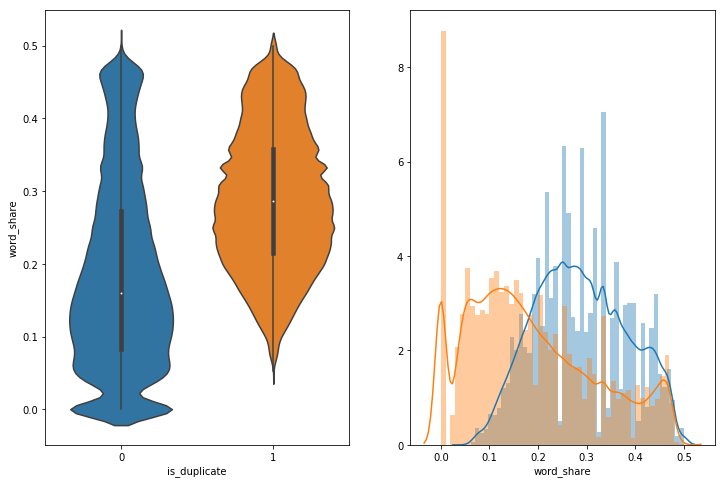

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1")
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0")
plt.show()

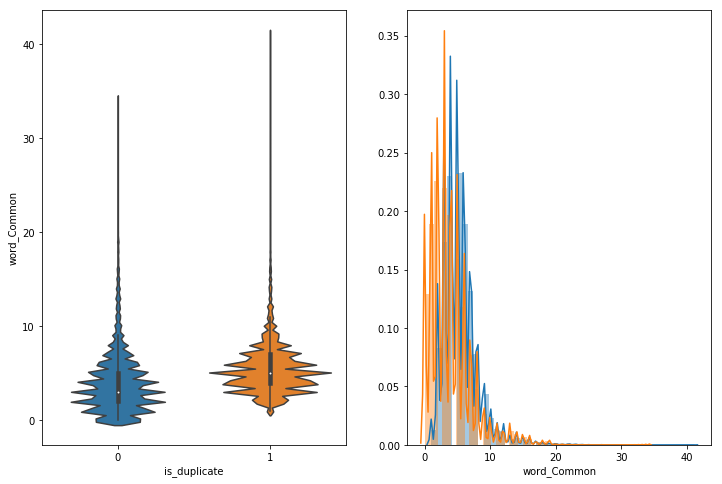

In [22]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1")
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0")
plt.show()

**Preprocessing of Text **
* Preprocessing:
* Removing html tags
* Removing Punctuations
* Performing stemming
* Removing Stopwords
* Expanding contractions etc.

In [23]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

****Advance feature extraction****

In [24]:

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [25]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("/kaggle/input/quora-question-pairs/train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..


id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max   ctc_min   ctc_max  last_word_eq  \
0  0.833319  0.999983  0.999983  0.916659  0.785709           0.0   
1  0.399996  0.749981  0.599988  0.699993  0.466664           0.0   

   first_word_eq  abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  \
0            1.0           2.0      13.0              100                93   
1            1.0           5.0      12.5               86                63   

   fuzz_ratio  fuzz_partial_ratio  
0          93                 100  
1          66                  75

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 20 columns):
id                    404290 non-null int64
qid1                  404290 non-null int64
qid2                  404290 non-null int64
question1             404290 non-null object
question2             404290 non-null object
is_duplicate          404290 non-null int64
cwc_min               404290 non-null float64
cwc_max               404290 non-null float64
csc_min               404290 non-null float64
csc_max               404290 non-null float64
ctc_min               404290 non-null float64
ctc_max               404290 non-null float64
last_word_eq          404290 non-null float64
first_word_eq         404290 non-null float64
abs_len_diff          404290 non-null float64
mean_len              404290 non-null float64
token_set_ratio       404290 non-null int64
token_sort_ratio      404290 non-null int64
fuzz_ratio            404290 non-null int64
fuzz_partial_ratio    404290 no

**Plotting Word clouds**

* Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
* We can observe the most frequent occuring words

In [27]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [28]:
# reading the text files and removing the Stop Words:
#d = path.dirname('/kaggle/working/')

textp_w = open('train_p.txt').read()
textn_w = open('train_n.txt').read()

stopwords = set(STOPWORDS)

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193067


Word Cloud for Duplicate Question pairs


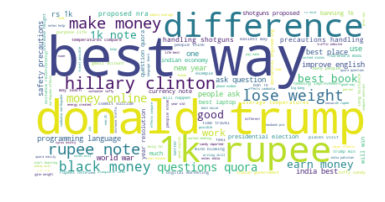

In [29]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


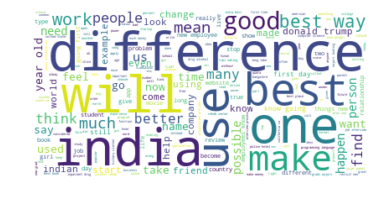

In [30]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

**Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] **

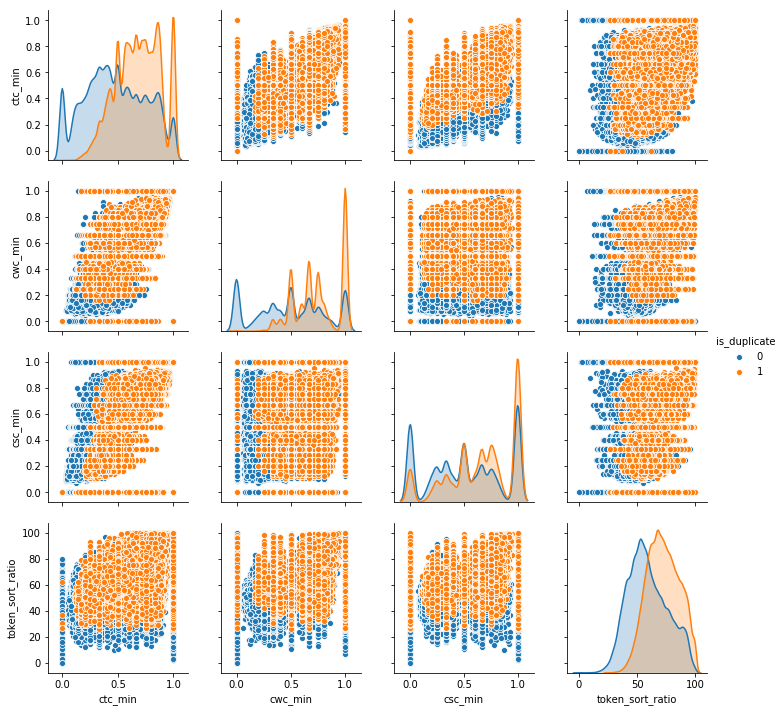

In [31]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

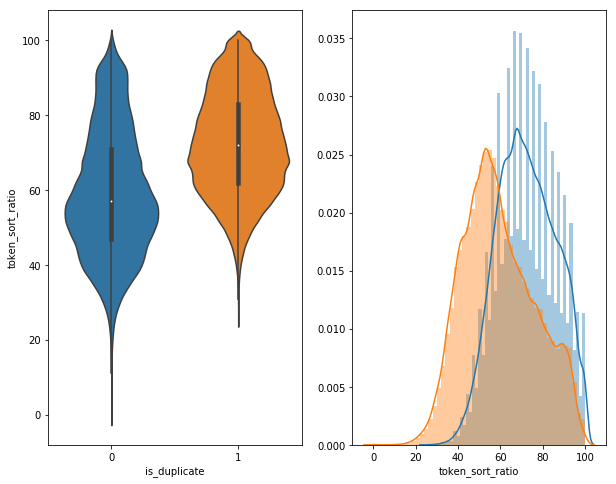

In [32]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1")
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" )
plt.show()

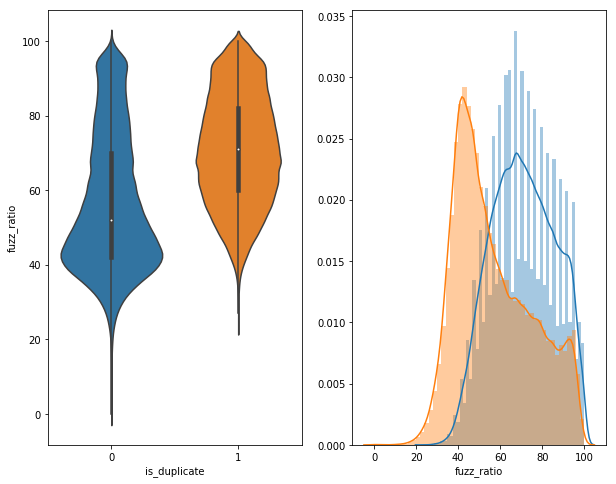

In [33]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1")
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0")
plt.show()

In [34]:
nlp_features_train = pd.read_csv('nlp_features_train.csv')
nlp_features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 20 columns):
id                    404290 non-null int64
qid1                  404290 non-null int64
qid2                  404290 non-null int64
question1             404275 non-null object
question2             404284 non-null object
is_duplicate          404290 non-null int64
cwc_min               404290 non-null float64
cwc_max               404290 non-null float64
csc_min               404290 non-null float64
csc_max               404290 non-null float64
ctc_min               404290 non-null float64
ctc_max               404290 non-null float64
last_word_eq          404290 non-null float64
first_word_eq         404290 non-null float64
abs_len_diff          404290 non-null float64
mean_len              404290 non-null float64
token_set_ratio       404290 non-null int64
token_sort_ratio      404290 non-null int64
fuzz_ratio            404290 non-null int64
fuzz_partial_ratio    404290 no

In [35]:
nlp_features_train.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1,inplace=True)
nlp_features_train.head(10)
nlp_features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 15 columns):
id                    404290 non-null int64
cwc_min               404290 non-null float64
cwc_max               404290 non-null float64
csc_min               404290 non-null float64
csc_max               404290 non-null float64
ctc_min               404290 non-null float64
ctc_max               404290 non-null float64
last_word_eq          404290 non-null float64
first_word_eq         404290 non-null float64
abs_len_diff          404290 non-null float64
mean_len              404290 non-null float64
token_set_ratio       404290 non-null int64
token_sort_ratio      404290 non-null int64
fuzz_ratio            404290 non-null int64
fuzz_partial_ratio    404290 non-null int64
dtypes: float64(10), int64(5)
memory usage: 46.3 MB


In [36]:
df_fe_without_preprocessing_train = pd.read_csv("df_fe_without_preprocessing_train.csv")
df_fe_without_preprocessing_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 17 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
freq_qid1       404290 non-null int64
freq_qid2       404290 non-null int64
q1len           404290 non-null int64
q2len           404290 non-null int64
q1_n_words      404290 non-null int64
q2_n_words      404290 non-null int64
word_Common     404290 non-null float64
word_Total      404290 non-null float64
word_share      404290 non-null float64
freq_q1+q2      404290 non-null int64
freq_q1-q2      404290 non-null int64
dtypes: float64(3), int64(12), object(2)
memory usage: 52.4+ MB


In [37]:
result  = nlp_features_train.merge(df_fe_without_preprocessing_train, on='id',how='left')

result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404290 entries, 0 to 404289
Data columns (total 31 columns):
id                    404290 non-null int64
cwc_min               404290 non-null float64
cwc_max               404290 non-null float64
csc_min               404290 non-null float64
csc_max               404290 non-null float64
ctc_min               404290 non-null float64
ctc_max               404290 non-null float64
last_word_eq          404290 non-null float64
first_word_eq         404290 non-null float64
abs_len_diff          404290 non-null float64
mean_len              404290 non-null float64
token_set_ratio       404290 non-null int64
token_sort_ratio      404290 non-null int64
fuzz_ratio            404290 non-null int64
fuzz_partial_ratio    404290 non-null int64
qid1                  404290 non-null int64
qid2                  404290 non-null int64
question1             404289 non-null object
question2             404288 non-null object
is_duplicate          404290 no

In [38]:
X = result.drop(['qid1','qid2','question1','question2','id'],axis=1)
y = result['is_duplicate']
X = X.drop(columns=['is_duplicate'],axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404290 entries, 0 to 404289
Data columns (total 25 columns):
cwc_min               404290 non-null float64
cwc_max               404290 non-null float64
csc_min               404290 non-null float64
csc_max               404290 non-null float64
ctc_min               404290 non-null float64
ctc_max               404290 non-null float64
last_word_eq          404290 non-null float64
first_word_eq         404290 non-null float64
abs_len_diff          404290 non-null float64
mean_len              404290 non-null float64
token_set_ratio       404290 non-null int64
token_sort_ratio      404290 non-null int64
fuzz_ratio            404290 non-null int64
fuzz_partial_ratio    404290 non-null int64
freq_qid1             404290 non-null int64
freq_qid2             404290 non-null int64
q1len                 404290 non-null int64
q2len                 404290 non-null int64
q1_n_words            404290 non-null int64
q2_n_words            404290 non-

**Training Model- Logistic Regression**

In [42]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size = 0.2, random_state = 0) 


from sklearn.linear_model import LogisticRegression 
model = LogisticRegression() 
model.fit(X_train, y_train) 
y_pred = model.predict(X_test)

import pickle

filename = open('Quora_Question_pairs_model.sav','ab')
pickle.dump(model,filename)
filename.close()

from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_test, y_pred) 

print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[44848  6139]
 [10743 19128]]


In [44]:
from sklearn import metrics
print("Accuracy: ",metrics.accuracy_score(y_pred,y_test)*100)

Accuracy:  79.12142274110168


In [55]:
dbfile = open('Quora_Question_pairs_model.sav', 'rb')      
model = pickle.load(dbfile) 
print("Accuracy: ",model.score(X_test,y_test)*100) 
dbfile.close() 

Accuracy:  79.12142274110168
